In [1]:
import sys
sys.path.append("./../../src")
import pandas as pd
import numpy as np

import torch
from torch import nn, optim
import pickle

from vae_with_dataloader import VAE, VAETrainerWithDataLoader
# from icd_analysis_helper import ICDAnalysisHelper
from dataloader import MixehrICDImputationDataset
from visualizer_helper import Visualizer



from config_reader import Config
import os
import math
from sklearn.model_selection import train_test_split

In [2]:
visualizer = Visualizer()

In [3]:
config = Config('./config.ini', date="200211")
experiment_name=config.experiment_name
config.__dict__

{'patient_icd_path': '/data1/andrew/meng/mixehr/data/Mimic/andrew_outputs/PATIENT_ICD_BINARY.csv',
 'icd9codes_path': '/data1/andrew/meng/mixehr/data/Mimic/mimic-iii-clinical-database-1.4/D_ICD_DIAGNOSES.csv.gz',
 'subject_ids_path': '/Users/andrew/Documents/meng/spring/PATIENT_ICD_SUBJECT_IDS.csv',
 'experiment_name': '200211_mixehr_imputation_icd9codes',
 'encoder_dim': [(250, 500), (500, 250), (250, 100)],
 'latent_dim': 25,
 'decoder_dim': [(250, 500), (500, 250), (250, 100)],
 'use_relu_encoder': True,
 'use_relu_decoder': True,
 'kld_beta': 1.0}

In [4]:
###Load Matrices
metaphe_path = "/Users/andrew/Documents/meng/mixEHR/data/precomputed_results/mixmimic/mimic_trainData_mimic_trainData_JCVB0_nmar_K75_iter5497_metaphe.csv"
icd_topic_distribution_path = "../../mixehr_analysis/imputed_data/mixehr_topics_normalized_FROM_ICD_DISTRIBUTION_with_phenames_icd_only.csv"

mixehr_icd_imputation_dataset = MixehrICDImputationDataset(patient_topic_distribution_path = metaphe_path, 
                                                           icd_topic_feature_distribution_path = icd_topic_distribution_path)

params = {'batch_size': 64,
          'shuffle': True}

mixehr_training_generator = torch.utils.data.DataLoader(mixehr_icd_imputation_dataset, **params)

In [5]:
###Load Model
print("Feature_dim: {}".format(mixehr_icd_imputation_dataset.get_feat_dim()))
model = VAE(
    feature_dim = mixehr_icd_imputation_dataset.get_feat_dim(),
    encoder_dim = config.encoder_dim,
    latent_dim = config.latent_dim,
    decoder_dim = config.decoder_dim,
    use_relu_encoder= config.use_relu_encoder,
    use_relu_decoder= config.use_relu_decoder
)

model = model.double()

optimizer = optim.Adam(model.parameters(), lr=0.001)
print(type(optimizer))

###Load Trainer
trainer = VAETrainerWithDataLoader(
    model=model, 
    optimizer=optimizer,
    experiment_name=config.experiment_name,
    kld_beta=config.kld_beta
)

Feature_dim: 7985
<class 'torch.optim.adam.Adam'>


In [6]:
##Load pre-trained model
epoch = 10
model.load_state_dict(torch.load("./VAE_exp_{}_epoch_{}.pkl".format(config.experiment_name, epoch)))
trainer.model = model

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
# ###Encode data

# encoding_params = {'batch_size': 64, 'shuffle': False}
# mixehr_encoding_generator = torch.utils.data.DataLoader(mixehr_icd_imputation_dataset, **encoding_params)

# latent, means, var = trainer.encode_data(mixehr_encoding_generator)

In [ ]:
###Encode and plot 2d Data

X_umap = pickle.load(open("X_umap.p", 'rb'))
mean_umap = pickle.load(open("mean_umap.p", 'rb'))
var_umap = pickle.load(open("var_umap.p", 'rb'))

alpha2d = 0.5
visualizer.plot2d(
    X=X_umap, 
    filename="Patient_Clusters_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_everyone"), 
    colors=[1 for i in range(X_umap.shape[0])],
    alpha = alpha2d
)

visualizer.plot2d(
    X=mean_umap, 
    filename="Patient_Clusters_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_everyone_means"), 
    colors=[1 for i in range(X_umap.shape[0])],
    alpha = alpha2d
)

visualizer.plot2d(
    X=var_umap, 
    filename="Patient_Clusters_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_everyone_vars"), 
    colors=[1 for i in range(X_umap.shape[0])],
    alpha = alpha2d
)

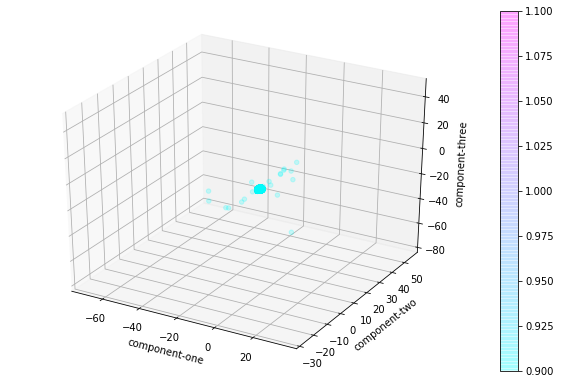

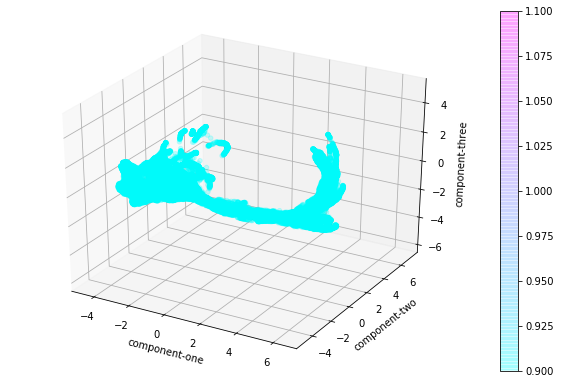

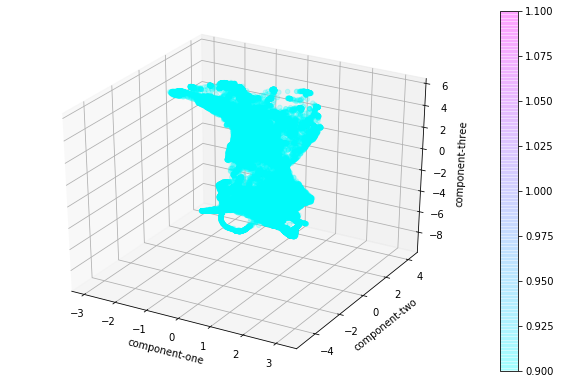

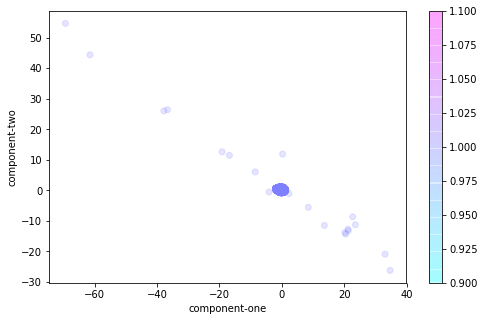

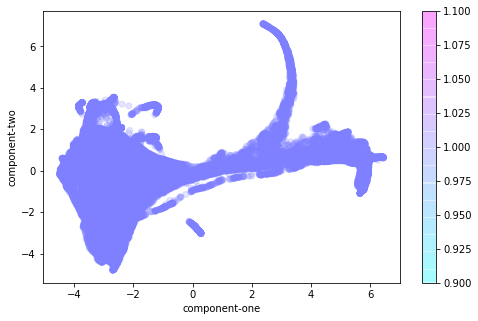

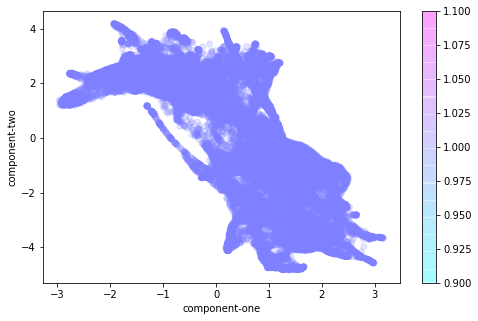

In [7]:
###Encode and plot 3d Data

X_umap_3d = pickle.load(open("X_umap_3d.p", 'rb'))
mean_umap_3d = pickle.load(open("mean_umap_3d.p", 'rb'))
var_umap_3d = pickle.load(open("var_umap_3d.p", 'rb'))

alpha3d = 0.2

visualizer.plot3d(
    X=X_umap_3d, 
    filename="Patient_Clusters_3D_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_everyone_imputed"), 
    colors=[1 for i in range(X_umap_3d.shape[0])],
    alpha = alpha3d
)

visualizer.plot3d(
    X=mean_umap_3d, 
    filename="Patient_Clusters_3D_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_everyone_imputed_means"), 
    colors=[1 for i in range(X_umap_3d.shape[0])],
    alpha = alpha3d
)

visualizer.plot3d(
    X=var_umap_3d, 
    filename="Patient_Clusters_3D_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_everyone_imputed_vars"), 
    colors=[1 for i in range(X_umap_3d.shape[0])],
    alpha = alpha3d
)

visualizer.plot2d(
    X=X_umap_3d[:, :-1], 
    filename="Patient_Clusters_2D_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_everyone_imputed_from_3d"), 
    colors=[1 for i in range(X_umap_3d.shape[0])],
    alpha = alpha3d
)

visualizer.plot2d(
    X=mean_umap_3d[:, :-1], 
    filename="Patient_Clusters_2D_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_everyone_imputed_means_from_3d"), 
    colors=[1 for i in range(X_umap_3d.shape[0])],
    alpha = alpha3d
)

visualizer.plot2d(
    X=var_umap_3d[:, :-1], 
    filename="Patient_Clusters_2D_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_everyone_imputed_vars_from_3d"), 
    colors=[1 for i in range(X_umap_3d.shape[0])],
    alpha = alpha3d
)

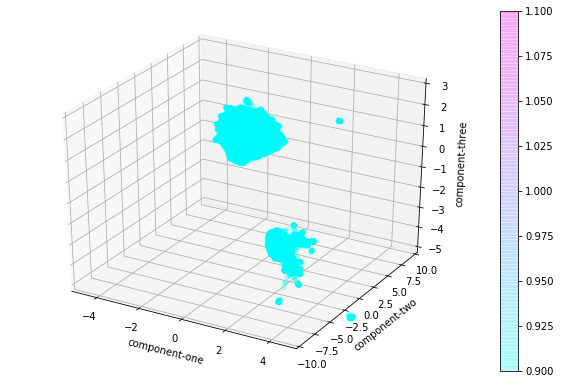

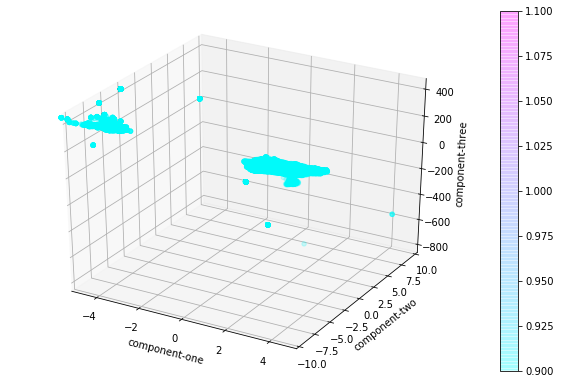

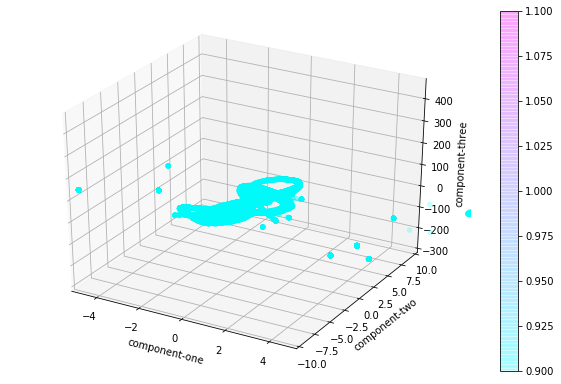

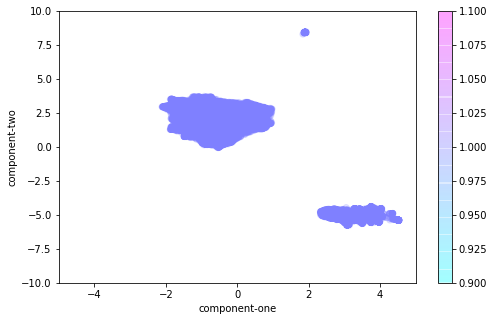

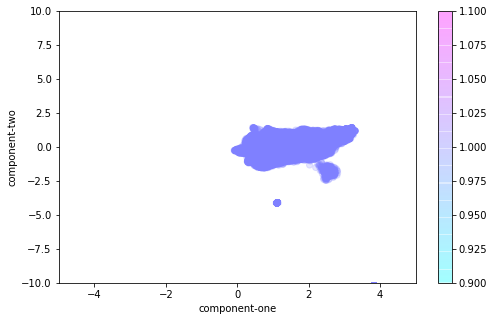

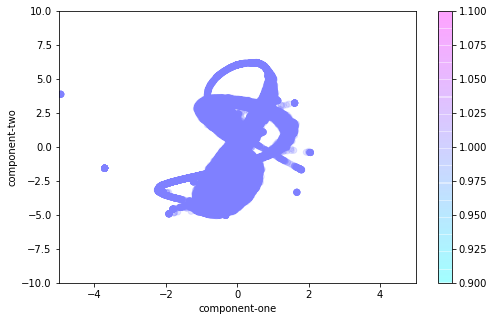

In [9]:
###Encode and plot 3d Data

X_umap_3d_v = pickle.load(open("X_umap_3d_vanilla.p", 'rb'))
mean_umap_3d_v = pickle.load(open("mean_umap_3d_vanilla.p", 'rb'))
var_umap_3d_v = pickle.load(open("var_umap_3d_vanilla.p", 'rb'))

alpha3d = 0.2

visualizer.plot3d(
    X=X_umap_3d_v, 
    filename="Patient_Clusters_3D_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_everyone_no_outlier"), 
    colors=[1 for i in range(X_umap_3d_v.shape[0])],
    alpha = alpha3d,
    xlim=(-5, 5),
    ylim=(-10, 10)
)

visualizer.plot3d(
    X=mean_umap_3d_v, 
    filename="Patient_Clusters_3D_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_everyone_means_no_outlier"), 
    colors=[1 for i in range(X_umap_3d_v.shape[0])],
    alpha = alpha3d,
    xlim=(-5, 5),
    ylim=(-10, 10)
)

visualizer.plot3d(
    X=var_umap_3d_v, 
    filename="Patient_Clusters_3D_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_everyone_vars_no_outlier"), 
    colors=[1 for i in range(X_umap_3d_v.shape[0])],
    alpha = alpha3d,
    xlim=(-5, 5),
    ylim=(-10, 10)
)

visualizer.plot2d(
    X=X_umap_3d_v[:, :-1], 
    filename="Patient_Clusters_2D_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_everyone_from_3d_no_outlier"), 
    colors=[1 for i in range(X_umap_3d_v.shape[0])],
    alpha = alpha3d, 
    xlim=(-5, 5),
    ylim=(-10, 10)
)

visualizer.plot2d(
    X=mean_umap_3d_v[:, :-1], 
    filename="Patient_Clusters_2D_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_everyone_means_from_3d_no_outlier"), 
    colors=[1 for i in range(X_umap_3d_v.shape[0])],
    alpha = alpha3d,
    xlim=(-5, 5),
    ylim=(-10, 10)
)

visualizer.plot2d(
    X=var_umap_3d_v[:, :-1], 
    filename="Patient_Clusters_2D_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_everyone_vars_from_3d_no_outlier"), 
    colors=[1 for i in range(X_umap_3d_v.shape[0])],
    alpha = alpha3d, 
    xlim=(-5, 5),
    ylim=(-10, 10)
)